# Premier League 2023/24 predictions

## Importing libraries

In [38]:
import pandas as pd

# Load the dataset from the excel file
file_path = 'all-euro-data-2023-2024.xlsx'
df = pd.read_excel(file_path, sheet_name='E0')

# Display the first few rows of the dataset
df.head()


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,I1,2023-08-19,17:30:00,Empoli,Verona,0,1,A,0,0,...,1.85,-0.25,2.02,1.91,2.01,1.92,2.03,1.98,1.94,1.90
1,I1,2023-08-19,17:30:00,Frosinone,Napoli,1,3,A,1,2,...,2.10,1.00,1.96,1.97,1.97,1.95,2.02,1.98,1.95,1.89
2,I1,2023-08-19,19:45:00,Genoa,Fiorentina,1,4,A,0,3,...,1.74,0.25,1.79,2.15,1.82,2.13,2.02,2.15,1.86,2.00
3,I1,2023-08-19,19:45:00,Inter,Monza,2,0,H,1,0,...,2.38,-1.25,1.92,2.01,1.91,2.02,1.94,2.05,1.87,1.98
4,I1,2023-08-20,17:30:00,Roma,Salernitana,2,2,D,1,1,...,1.68,-1.00,1.95,1.98,1.94,1.98,2.03,2.03,1.92,1.93


## Data cleaning

In [39]:
# steps:
# 1. Check for missing values
missing_values = df.isnull().sum()

# 2. Check for duplicates
duplicate_rows = df.duplicated().sum()

# Display the results of the checks
missing_values, duplicate_rows

(Div         0
 Date        0
 Time        0
 HomeTeam    0
 AwayTeam    0
            ..
 PCAHA       0
 MaxCAHH     0
 MaxCAHA     0
 AvgCAHH     0
 AvgCAHA     0
 Length: 105, dtype: int64,
 0)

In [40]:
# Dropping columns with a high number of missing values or irrelevant to our analysis
irrelevant_columns = df.columns[df.isnull().sum() > (0.5 * len(df))]  # Columns with more than 50% missing values
df_cleaned = df.drop(columns=irrelevant_columns)

# Convert 'Date' to datetime
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Fill missing values in other relevant columns with appropriate values (like median or mode)
# For numerical columns, we use median and for categorical, we use mode
for column in df_cleaned.columns:
    if df_cleaned[column].dtype == 'object':
        df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)
    else:
        df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)

# Recheck for missing values
remaining_missing_values = df_cleaned.isnull().sum().sum()

# Basic information after cleaning
remaining_missing_values, df_cleaned.info()

df_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Columns: 105 entries, Div to AvgCAHA
dtypes: datetime64[ns](1), float64(82), int64(16), object(6)
memory usage: 131.4+ KB


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,I1,2023-08-19,17:30:00,Empoli,Verona,0,1,A,0,0,...,1.85,-0.25,2.02,1.91,2.01,1.92,2.03,1.98,1.94,1.90
1,I1,2023-08-19,17:30:00,Frosinone,Napoli,1,3,A,1,2,...,2.10,1.00,1.96,1.97,1.97,1.95,2.02,1.98,1.95,1.89
2,I1,2023-08-19,19:45:00,Genoa,Fiorentina,1,4,A,0,3,...,1.74,0.25,1.79,2.15,1.82,2.13,2.02,2.15,1.86,2.00
3,I1,2023-08-19,19:45:00,Inter,Monza,2,0,H,1,0,...,2.38,-1.25,1.92,2.01,1.91,2.02,1.94,2.05,1.87,1.98
4,I1,2023-08-20,17:30:00,Roma,Salernitana,2,2,D,1,1,...,1.68,-1.00,1.95,1.98,1.94,1.98,2.03,2.03,1.92,1.93


## Feature engineering

### steps:
* Encode Team Names: Use label encoding for 'HomeTeam' and 'AwayTeam'. This will convert team names into numeric values, making them usable for the model.

* Recent Form: Calculate the recent form for each team based on the last 5 matches. We'll use the 'FTR' column to determine wins (W), losses (L), and draws (D). This feature will provide insight into the current performance of the teams.

* Average Goals per Game: Compute the average goals scored per game for both home and away teams. This feature helps understand the offensive strength of the teams.

* Team Points: Calculate the total points accumulated by each team so far in the season. Points are awarded based on wins (3 points), draws (1 point), and losses (0 points).

* Head-to-Head Statistics: Analyze the outcomes of matches between the same pairs of teams earlier in the season.

* Other Statistical Features: Depending on the data available, we can include additional features like average possession, number of shots on target, defensive strength, etc.

## Encode team names

In [41]:
# Import the LabelEncoder class from the sklearn library
from sklearn.preprocessing import LabelEncoder

# Encode the team names
label_encoder = LabelEncoder()
df_cleaned['HomeTeamEncoded'] = label_encoder.fit_transform(df_cleaned['HomeTeam'])
df_cleaned['AwayTeamEncoded'] = label_encoder.transform(df_cleaned['AwayTeam'])


## Recent form

In [42]:
# function to calculate recent form
def calculate_form_points(team, df_cleaned, num_matches=5):
    # Filter the matches for the team
    team_matches = df_cleaned[(df_cleaned['HomeTeam'] == team) | (df_cleaned['AwayTeam'] == team)]
    # Sort by date to get the most recent matches
    team_matches = team_matches.sort_values(by='Date', ascending=False)
    # Get the last 'num_matches' matches
    recent_matches = team_matches.head(num_matches)
    # Calculate form points
    form_points = 0
    for _, row in recent_matches.iterrows():
        if row['HomeTeam'] == team and row['FTR'] == 'H':
            form_points += 3
        elif row['AwayTeam'] == team and row['FTR'] == 'A':
            form_points += 3
        elif row['FTR'] == 'D':
            form_points += 1
    return form_points

# Apply the function to get recent form for each team in each match
df_cleaned['HomeTeamRecentForm'] = df_cleaned.apply(lambda x: calculate_form_points(x['HomeTeam'], df_cleaned), axis=1)
df_cleaned['AwayTeamRecentForm'] = df_cleaned.apply(lambda x: calculate_form_points(x['AwayTeam'], df_cleaned), axis=1)

# Average Goals per Game
df_cleaned['HomeTeamAvgGoals'] = df_cleaned.groupby('HomeTeam')['FTHG'].transform('mean')
df_cleaned['AwayTeamAvgGoals'] = df_cleaned.groupby('AwayTeam')['FTAG'].transform('mean')



## Team Points

In [43]:
# Points will be calculated similar to form but for the whole season
def calculate_team_points(team, df_cleaned):
    team_matches = df_cleaned[(df_cleaned['HomeTeam'] == team) | (df_cleaned['AwayTeam'] == team)]
    points = 0
    for _, row in team_matches.iterrows():
        if row['HomeTeam'] == team and row['FTR'] == 'H':
            points += 3
        elif row['AwayTeam'] == team and row['FTR'] == 'A':
            points += 3
        elif row['FTR'] == 'D':
            points += 1
    return points

df_cleaned['HomeTeamPoints'] = df_cleaned.apply(lambda x: calculate_team_points(x['HomeTeam'], df_cleaned), axis=1)
df_cleaned['AwayTeamPoints'] = df_cleaned.apply(lambda x: calculate_team_points(x['AwayTeam'], df_cleaned), axis=1)


## Head-to-Head Statistics

In [44]:
# Head-to-Head Statistics
# For simplicity, we can count the number of wins, draws, and losses in matches between the same teams
# Note: This implementation is simplified for demonstration purposes
def head_to_head_stats(home_team, away_team, df_cleaned):
    head_to_head_matches = df_cleaned[(df_cleaned['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team)]
    wins = len(head_to_head_matches[head_to_head_matches['FTR'] == 'H'])
    draws = len(head_to_head_matches[head_to_head_matches['FTR'] == 'D'])
    losses = len(head_to_head_matches[head_to_head_matches['FTR'] == 'A'])
    return wins, draws, losses

# Apply the head-to-head stats function
df_cleaned['HeadToHeadWins'], df_cleaned['HeadToHeadDraws'], df_cleaned['HeadToHeadLosses'] = zip(*df_cleaned.apply(lambda x: head_to_head_stats(x['HomeTeam'], x['AwayTeam'], df_cleaned), axis=1))

In [45]:
# Calculate Home Team Win Percentage
home_team_wins = df_cleaned[df_cleaned['FTR'] == 'H'].groupby('HomeTeam').size()
total_home_matches = df_cleaned.groupby('HomeTeam').size()
home_team_win_percentage = home_team_wins / total_home_matches
# 
# Calculate Away Team Win Percentage
away_team_wins = df_cleaned[df_cleaned['FTR'] == 'A'].groupby('AwayTeam').size()
total_away_matches = df_cleaned.groupby('AwayTeam').size()
away_team_win_percentage = away_team_wins / total_away_matches
# 
# Create mappings for win percentages
home_team_win_percentage_map = home_team_win_percentage.to_dict()
away_team_win_percentage_map = away_team_win_percentage.to_dict()
# 
# Map the win percentages to the original DataFrame
df_cleaned['HomeTeamWinPercentage'] = df_cleaned['HomeTeam'].map(home_team_win_percentage_map).fillna(0)
df_cleaned['AwayTeamWinPercentage'] = df_cleaned['AwayTeam'].map(away_team_win_percentage_map).fillna(0)
# 
# Check the first few rows to confirm the new features
print(df_cleaned[['HomeTeam', 'HomeTeamWinPercentage', 'AwayTeam', 'AwayTeamWinPercentage']].head())

    HomeTeam  HomeTeamWinPercentage     AwayTeam  AwayTeamWinPercentage
0     Empoli                  0.125       Verona               0.111111
1  Frosinone                  0.625       Napoli               0.625000
2      Genoa                  0.375   Fiorentina               0.375000
3      Inter                  0.750        Monza               0.250000
4       Roma                  0.625  Salernitana               0.000000


In [46]:
df_cleaned.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AwayTeamRecentForm,HomeTeamAvgGoals,AwayTeamAvgGoals,HomeTeamPoints,AwayTeamPoints,HeadToHeadWins,HeadToHeadDraws,HeadToHeadLosses,HomeTeamWinPercentage,AwayTeamWinPercentage
0,I1,2023-08-19,17:30:00,Empoli,Verona,0,1,A,0,0,...,3,0.625,0.666667,12,11,0,0,1,0.125,0.111111
1,I1,2023-08-19,17:30:00,Frosinone,Napoli,1,3,A,1,2,...,6,1.750,2.000000,19,27,0,0,1,0.625,0.625000
2,I1,2023-08-19,19:45:00,Genoa,Fiorentina,1,4,A,0,3,...,10,1.375,1.375000,16,27,0,0,1,0.375,0.375000
3,I1,2023-08-19,19:45:00,Inter,Monza,2,0,H,1,0,...,5,2.625,0.750000,41,21,1,0,0,0.750,0.250000
4,I1,2023-08-20,17:30:00,Roma,Salernitana,2,2,D,1,1,...,4,2.375,0.625000,25,8,0,1,0,0.625,0.000000


In [47]:
# get the current position and calculate points for chelsea and the rest of the teams
def calculate_points_goals(row):
    home_points, away_points = 0, 0
    home_goal_diff = row['FTHG'] - row['FTAG']
    away_goal_diff = row['FTAG'] - row['FTHG']

    if row['FTR'] == 'H':
        home_points = 3
    elif row['FTR'] == 'A':
        away_points = 3
    else:
        home_points = away_points = 1

    return pd.Series([home_points, away_points, home_goal_diff, away_goal_diff, row['FTHG'], row['FTAG']])

# List of teams
teams = df_cleaned['HomeTeam'].unique()

# Applying the function to the dataset
df_cleaned[['HomePoints', 'AwayPoints', 'HomeGoalDiff', 'AwayGoalDiff', 'HomeGoals', 'AwayGoals']] = df_cleaned.apply(calculate_points_goals, axis=1)

# Summarizing the data for each team
team_stats = pd.DataFrame(index=teams)

# Calculating total points, goal difference, and goals scored for each team
team_stats['Points'] = df_cleaned.groupby('HomeTeam')['HomePoints'].sum() + df_cleaned.groupby('AwayTeam')['AwayPoints'].sum()
team_stats['GoalDiff'] = df_cleaned.groupby('HomeTeam')['HomeGoalDiff'].sum() + df_cleaned.groupby('AwayTeam')['AwayGoalDiff'].sum()
team_stats['GoalsScored'] = df_cleaned.groupby('HomeTeam')['HomeGoals'].sum() + df_cleaned.groupby('AwayTeam')['AwayGoals'].sum()

# Sorting the teams based on Points, Goal Difference, and Goals Scored
sorted_teams = team_stats.sort_values(by=['Points', 'GoalDiff', 'GoalsScored'], ascending=[False, False, False])

# Finding Chelsea's position
chelsea_position_updated = sorted_teams.index.get_loc('Chelsea') + 1
print('Chelsea is currently in position:', chelsea_position_updated)
sorted_teams.head(), chelsea_position_updated


Inter is currently in position: 1


(          Points  GoalDiff  GoalsScored
 Inter         41        32           39
 Juventus      37        14           24
 Milan         32        11           29
 Bologna       28         8           20
 Napoli        27         9           28,
 1)

## Data Preprocessing
### steps:
* Scaling Numeric Features: We'll scale features like recent form, average goals, and points using StandardScaler.
* Handling Categorical Variables: We have already encoded team names. We'll ensure other categorical features, if any, are properly encoded.
* Splitting the Data: We'll split the data into training and test sets. We'll use the training set to train the model and the test set to evaluate the model's performance on unseen data.

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# select relevant columns or features
features = ['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage']
target = 'FTR'

# Split the data into training and test sets
X = df_cleaned[features]
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Addressing Class Imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

## Hyperparameter Tuning

In [49]:
from hyperopt import hp
import numpy as np
# Define the hyperparameter space
space = {
    'iterations': hp.quniform('iterations', 100, 1000, 50),
    'depth': hp.choice('depth', np.arange(3, 11, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 0, 1)
    
}


## Creating the Objective Function so that we can use it in the hyperparameter optimization

In [50]:
from hyperopt import STATUS_OK
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier

def objective(params):
    params['iterations'] = int(params['iterations'])
    clf = CatBoostClassifier(**params, loss_function='MultiClass', verbose=False)
    score = cross_val_score(clf, X_train_scaled, y_train_smote, scoring='accuracy', cv=StratifiedKFold(6)).mean()
    return {'loss': -score, 'status': STATUS_OK}



In [51]:
# run the hyperparameter optimization
from hyperopt import tpe, Trials, fmin

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)


100%|██████████| 20/20 [01:55<00:00,  5.76s/trial, best loss: -0.6841133004926108]


In [52]:
from sklearn.metrics import classification_report

best_params = {k: int(v) if k in ['iterations', 'depth'] else v for k, v in best.items()}
final_model = CatBoostClassifier(**best_params, loss_function='MultiClass', eval_metric='Accuracy', verbose=False)
final_model.fit(X_train_scaled, y_train_smote)

# Evaluate the model
y_pred = final_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

           A       0.57      0.50      0.53         8
           D       0.33      0.50      0.40         8
           H       0.69      0.56      0.62        16

    accuracy                           0.53        32
   macro avg       0.53      0.52      0.52        32
weighted avg       0.57      0.53      0.54        32


In [53]:
# check for overfitting
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(final_model, X_train_scaled, y_train_smote, cv=6)

# Print the average score
print(f"Average Cross-Validation Score: {cv_scores.mean()}")


Average Cross-Validation Score: 0.6664614121510674


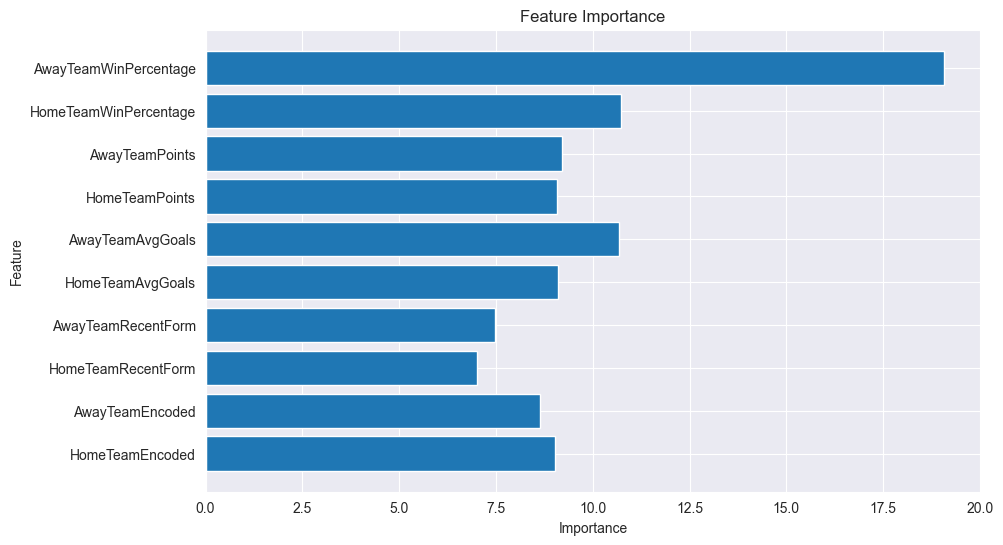

In [54]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = final_model.get_feature_importance()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


In [55]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, final_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = final_model.predict_proba(match_scaled)[0][0]
    away_team_win_prob = final_model.predict_proba(match_scaled)[0][2]
    draw_prob = final_model.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob

predict_match('West Ham', 'Man United', final_model, scaler)
predict_match('Tottenham', 'Everton', final_model, scaler)
predict_match("Nott'm Forest", 'Bournemouth', final_model, scaler)
predict_match('Luton', 'Newcastle', final_model, scaler)
predict_match('Liverpool', 'Arsenal', final_model, scaler)
predict_match('Wolves', 'Chelsea', final_model, scaler)



Inter win probability: 0.12163151363286229
Lecce win probability: 0.6639562766003533
Draw probability: 0.21441220976678446
Roma win probability: 0.5866722319916442
Napoli win probability: 0.21809489130190018
Draw probability: 0.19523287670645556


(0.5866722319916442, 0.21809489130190018, 0.19523287670645556)

In [56]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Addressing Class Imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    
}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train_scaled, y_train_smote)

# Best Model Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.62      0.62      0.62         8
           D       0.33      0.50      0.40         8
           H       0.67      0.50      0.57        16

    accuracy                           0.53        32
   macro avg       0.54      0.54      0.53        32
weighted avg       0.57      0.53      0.54        32


In [57]:
# check for overfitting
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train_smote, cv=6)

# Print the average score
print(f"Average Cross-Validation Score: {cv_scores.mean()}")


Average Cross-Validation Score: 0.6664614121510672


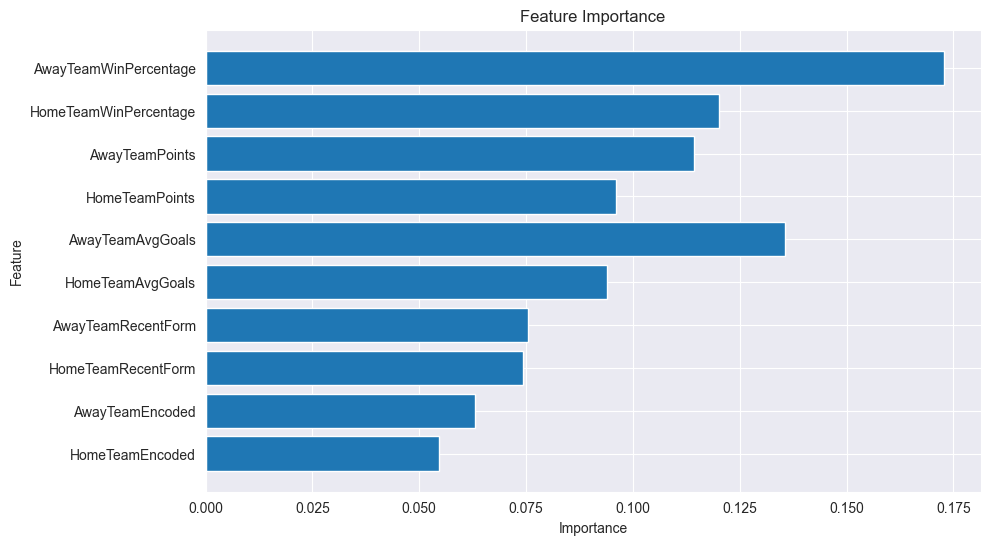

In [58]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [59]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, best_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = best_model.predict_proba(match_scaled)[0][0]
    away_team_win_prob = best_model.predict_proba(match_scaled)[0][2]
    draw_prob = best_model.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob

predict_match('West Ham', 'Man United', best_model, scaler)
predict_match('Tottenham', 'Everton', best_model, scaler)
predict_match("Nott'm Forest", 'Bournemouth', best_model, scaler)
predict_match('Luton', 'Newcastle', best_model, scaler)
predict_match('Liverpool', 'Arsenal', best_model, scaler)


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# compare the two models
from sklearn.metrics import classification_report

# Evaluate the model
y_pred = final_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))

# Evaluate the model
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))


In [ ]:
# plot the model comparison
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame with the results
model_comparison = pd.DataFrame({'model': ['CatBoost', 'Random Forest'], 'accuracy': [0.59, 0.62]})
# Plot the results
plt.figure(figsize=(8, 6))

sns.barplot(x='model', y='accuracy', data=model_comparison)
plt.ylim(0, 1)
plt.title('Model Comparison')
plt.show()



In [ ]:
predict_match('Wolves', 'Chelsea', best_model, scaler)


In [ ]:
# save the model
import pickle

pickle.dump(best_model, open('best_model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))



In [ ]:
# load the model
import pickle

best_model = pickle.load(open('best_model.pkl', 'rb'))
scaler = pickle.load(open('scaler.pkl', 'rb'))
label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))



In [ ]:
predict_match('Wolves', 'Chelsea', best_model, scaler)

In [363]:
# streamlit app
import streamlit as st

# Title
st.title('Premier League 2023/24 Predictions')

# Sidebar
st.sidebar.header('User Input Features')

# Collect user input features into DataFrame
def user_input_features():
    home_team = st.sidebar.selectbox('Home Team', df_cleaned['HomeTeam'].unique())
    away_team = st.sidebar.selectbox('Away Team', df_cleaned['AwayTeam'].unique())
    data = {'HomeTeam': home_team, 'AwayTeam': away_team}
    features = pd.DataFrame(data, index=[0])
    return features

df_user = user_input_features()

# Display user input features
st.subheader('User Input Features')
st.write(df_user)

# Convert user input into DataFrame

# Create a dataframe with the appropriate format
match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage'])


match.loc[0] = [label_encoder.transform([df_user['HomeTeam'].values[0]])[0], label_encoder.transform([df_user['AwayTeam'].values[0]])[0], calculate_form_points(df_user['HomeTeam'].values[0], df_cleaned), calculate_form_points(df_user['AwayTeam'].values[0], df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == df_user['HomeTeam'].values[0]]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == df_user['AwayTeam'].values[0]]['AwayTeamAvgGoals'].values[0], calculate_team_points(df_user['HomeTeam'].values[0], df_cleaned), calculate_team_points(df_user['AwayTeam'].values[0], df_cleaned), home_team_win_percentage[df_user['HomeTeam'].values[0]], away_team_win_percentage[df_user['AwayTeam'].values[0]]]

# Scale the features
match_scaled = scaler.transform(match)

# Make predictions
home_team_win_prob = best_model.predict_proba(match_scaled)[0][0]
away_team_win_prob = best_model.predict_proba(match_scaled)[0][2]
draw_prob = best_model.predict_proba(match_scaled)[0][1]

# Print the results
st.subheader('Prediction')
st.write(f"{df_user['HomeTeam'].values[0]} win probability: {home_team_win_prob}")
st.write(f"{df_user['AwayTeam'].values[0]} win probability: {away_team_win_prob}")
st.write(f"Draw probability: {draw_prob}")



In [365]:
# using the model to predict final positio of the teams just like the def function calculate_points_goals(row)
# List of teams
teams = df_cleaned['HomeTeam'].unique()

# Applying the function to the dataset
df_cleaned[['HomePoints', 'AwayPoints', 'HomeGoalDiff', 'AwayGoalDiff', 'HomeGoals', 'AwayGoals']] = df_cleaned.apply(calculate_points_goals, axis=1)

# Summarizing the data for each team
team_stats = pd.DataFrame(index=teams)

# Calculating total points, goal difference, and goals scored for each team
team_stats['Points'] = df_cleaned.groupby('HomeTeam')['HomePoints'].sum() + df_cleaned.groupby('AwayTeam')['AwayPoints'].sum()

# Sorting the teams based on Points, Goal Difference, and Goals Scored
sorted_teams = team_stats.sort_values(by=['Points'], ascending=[False])

# Finding Chelsea's position
chelsea_position_updated = sorted_teams.index.get_loc('Chelsea') + 1
print('Chelsea is currently in position:', chelsea_position_updated)
sorted_teams.head(), chelsea_position_updated

# predict the final position of the teams

def predict_position(team, best_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage'])
    match.loc[0] = [label_encoder.transform([team])[0], label_encoder.transform([team])[0], calculate_form_points(team, df_cleaned), calculate_form_points(team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == team]['AwayTeamAvgGoals'].values[0], calculate_team_points(team, df_cleaned), calculate_team_points(team, df_cleaned), home_team_win_percentage[team], away_team_win_percentage[team]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    team_win_prob = best_model.predict_proba(match_scaled)[0][0]
    # Print the results
    print(f"{team} win probability: {team_win_prob}")
    print(f"{team} final position: {team_win_prob}")
    
    return team_win_prob

predict_position('Chelsea', best_model, scaler)